In [619]:
%load_ext autoreload
%autoreload 2

# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import pickle
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download Yahoo Data (5 minute interval)

In [621]:
import YahooStocks

tix = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"
# Initialize
stocks = YahooStocks.Stocks(tix)
# Download Yahoo and transform
stocks.get_data(interval = '5m')
stocks.transform_data()
# Write to transformed data to SQL
stocks.insert_SQL()
# Read from SQL
stocks.read_SQL('stockprice')

[*********************100%***********************]  21 of 21 completed


In [622]:
stocks.raw_data.shape

(390, 126)

In [623]:
stocks.transformed_data.to_csv('data/mydata.csv')

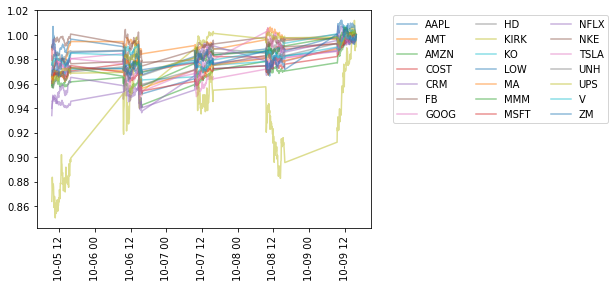

In [624]:
stocks.plot_raw(scale = -1)

# Model

In [625]:
# Prepare Data
# Pivot so each stock time series is a column
data = stocks.transformed_data.pivot_table(columns = 'symbol', index = 'DateTime')['price']
# Normalize by Last Value
data = data/data.iloc[-1]
data.index = pd.DatetimeIndex(data.index).to_period('M')

# Out of Sample Validation (MASE)

https://robjhyndman.com/papers/forecast-accuracy.pdf
page 7. 

Using All data for each Q

In [626]:
Q = np.abs(data.diff().dropna()).mean()

In [627]:
data.shape[0]

390

In [628]:
# Calculate MASE for VAR and Naive Model Using Q for all data of each series. This means, for example,
# AMZN predictions from any modeled are scaled by the same Q
MASE = []
MASEN = []
lags = int(data.shape[0]*.6)
print(lags)
# Rolling origin point forecast
for n in range((lags + 3),(data.shape[0] - 1)):
    M = YahooStocks.Model(data=data.iloc[0:n])
    M.fitVAR(lags)
    M.forecast(1)
    MAEnaive = np.abs(M.data.diff()).dropna().iloc[-1].values
    MAE = np.abs((data.iloc[n].values - M.fcast.values)[0])
    #print(np.mean(MAE/Q))
    MASE.append(MAE/Q)
    MASEN.append(MAEnaive/Q)
#print(np.mean(MASEN))

234


# Significance Testing

In [629]:
# Across All Stocks, how does VAR compare to Naive?
# Not much different
A = pd.DataFrame(MASE).melt()['value']
B = pd.DataFrame(MASEN).melt()['value']
print(np.mean(A))
print(np.mean(B))
stats.ttest_rel(A, B)

0.8961734517658871
0.8586747374886301


Ttest_relResult(statistic=1.7238692380867235, pvalue=0.08482830932540554)

In [630]:
#just to remind myself...
#stats.ttest_1samp(A - B, 0)
#stats.ttest_rel(pd.DataFrame(MASE)['AAPL'], pd.DataFrame(MASEN)['AAPL'])

In [631]:
# pairwise ttest between naive and var. Nobody looks significant, e.g. aapl naive to aapl var for all stocks
F, p = stats.f_oneway(np.array(MASE), np.array(MASEN), axis = 0)
p

array([0.60439671, 0.35780972, 0.87214308, 0.73819079, 0.72447717,
       0.30200601, 0.8958362 , 0.74045551, 0.70140222, 0.7513338 ,
       0.89727787, 0.99106995, 0.73412769, 0.72141308, 0.70267489,
       0.39410358, 0.62400377, 0.98532312, 0.47079998, 0.62605551,
       0.4933237 ])

In [632]:
# Are there any stocks that do better than others. Not really.
stats.f_oneway(*np.array(pd.DataFrame(MASE) - pd.DataFrame(MASEN)).T, axis = 0)

F_onewayResult(statistic=0.10870186775628617, pvalue=0.9999997573159938)

0.03749871427725704


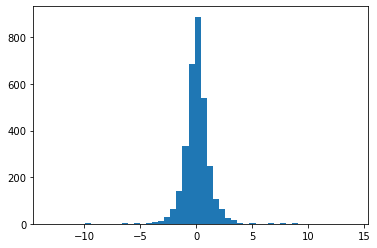

In [633]:
plt.hist(A - B, bins = 50)
print(np.mean(A - B))
plt.show()

# Forecast

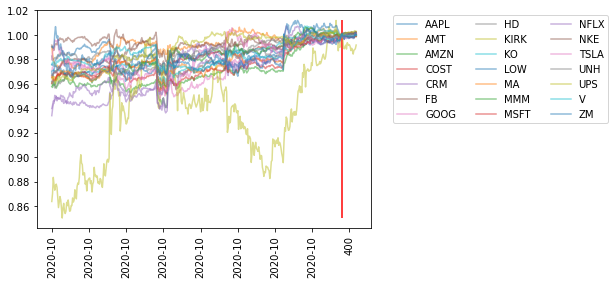

In [604]:
M = YahooStocks.Model(data=data)
M.fitVAR(lags)
M.forecast(20)
M.plot_fcast()

In [605]:
M.fcast.iloc[0].sort_values(ascending = False)

symbol
LOW     1.001225
HD      1.001054
ZM      1.001006
UPS     1.000734
GOOG    1.000425
MA      1.000408
AMZN    1.000377
FB      1.000305
KO      1.000297
V       1.000259
COST    1.000237
AMT     1.000236
UNH     1.000216
MMM     1.000177
TSLA    1.000126
NKE     1.000074
AAPL    0.999874
MSFT    0.999785
CRM     0.999725
NFLX    0.999085
KIRK    0.997822
Name: 390, dtype: float64